# [Lab Session 4](deconvolution.ipynb)

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import scipy

from skimage.restoration import wiener
from scipy.signal import convolve2d as conv
from scipy.stats import multivariate_normal as multi_normal

np.random.seed(0)

Load the image.

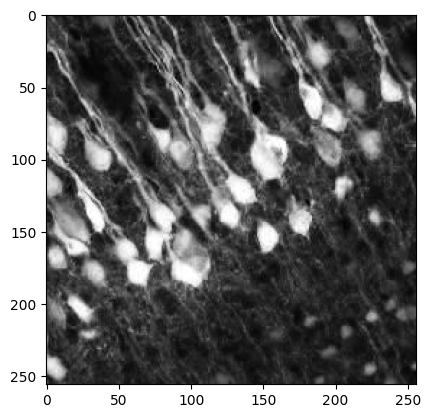

In [70]:
img = plt.imread('data/cells.png')[128:384, 128:384]
plt.imshow(img, 'gray')

**[Task 1.]()** Apply the following PSF to the image and then display it.

In [71]:
psf_size = 10
psf_uniform = np.ones((psf_size, psf_size)) / psf_size ** 2

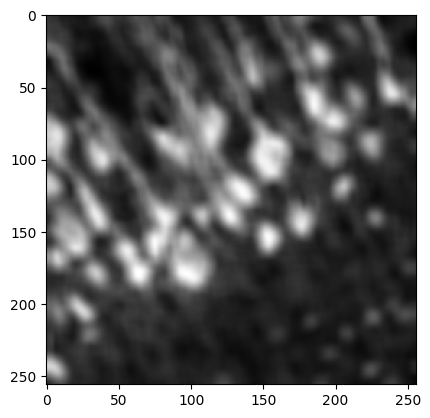

In [72]:
blurred_uniform = conv(img, psf_uniform, mode="same", boundary="symm")

plt.figure()    
plt.imshow(blurred_uniform, 'gray')

**[Task 2.]()** Have a look at the Gaussian PSF which is not uniformly distributed. Apply it to the image.

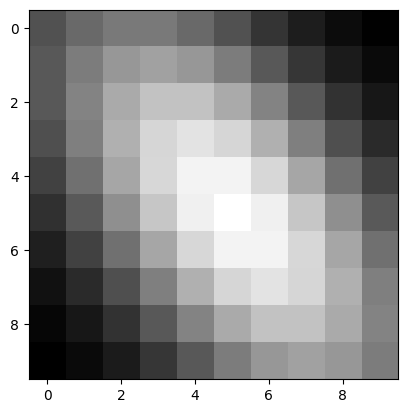

In [73]:
def create_psf(size):
    factor = size * 1.8
    x, y = np.mgrid[0:size:1, 0:size:1]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y
    rv = multi_normal([int(size / 2), (int(size / 2))], [[factor * 1., factor * 1.2], [factor * .5, factor * .7]])
    return rv.pdf(pos)

plt.imshow(create_psf(psf_size), 'gray')

Apply the second psf to the image:

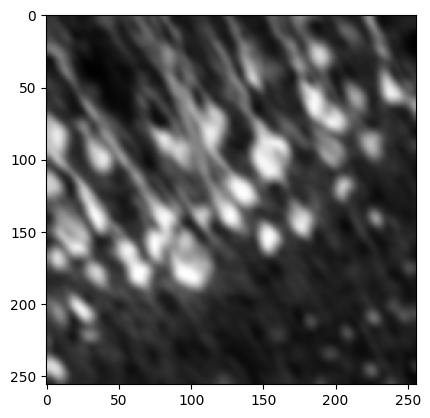

In [74]:
psf_gauss = create_psf(psf_size)
blurred_gauss = conv(img, psf_gauss, mode="same", boundary="symm")

plt.figure()    
plt.imshow(blurred_gauss, 'gray')

**[Task 3.]()** Implement a reusable function that performs the Richardson-Lucy deconvolution.

In [75]:
def richardson_lucy_deconvolution(image, psf, n_iterations):
    img_deconv = np.full(image.shape, 0.5) # = h(t)
    flipped_psf = np.flip(psf) # = p*

    for i in range(n_iterations):
        # = h(t) * p
        nenner = conv(img_deconv, psf, mode = "same", boundary = "symm")

        # = g(t) / (h(t) * p)
        mult1 = image / nenner
        # = (g(t) / (h(t) * p)) * p*
        klammer = conv(mult1, flipped_psf, mode = "same", boundary = "symm")

        img_deconv = img_deconv * klammer
        
    
    img_deconv = img_deconv.clip(0,1)
    return img_deconv

**[Task 4.]()** Apply the Richardson-Lucy deconvolution to the blurred image.

In [76]:
deconv_uniform = richardson_lucy_deconvolution(blurred_uniform, psf_uniform, 100)
deconv_gauss = richardson_lucy_deconvolution(blurred_gauss, psf_gauss, 100)

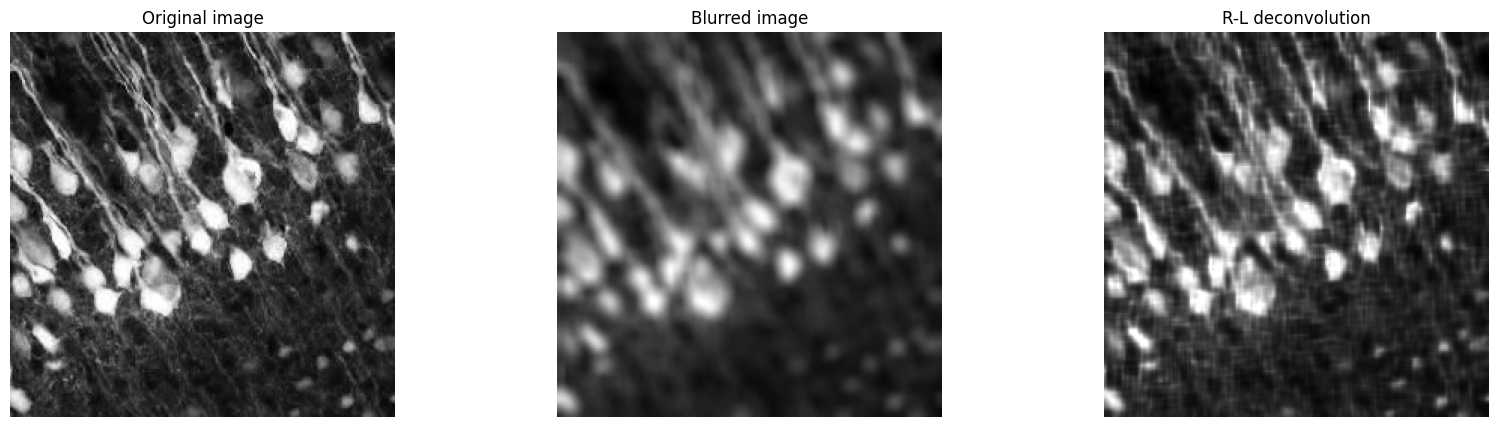

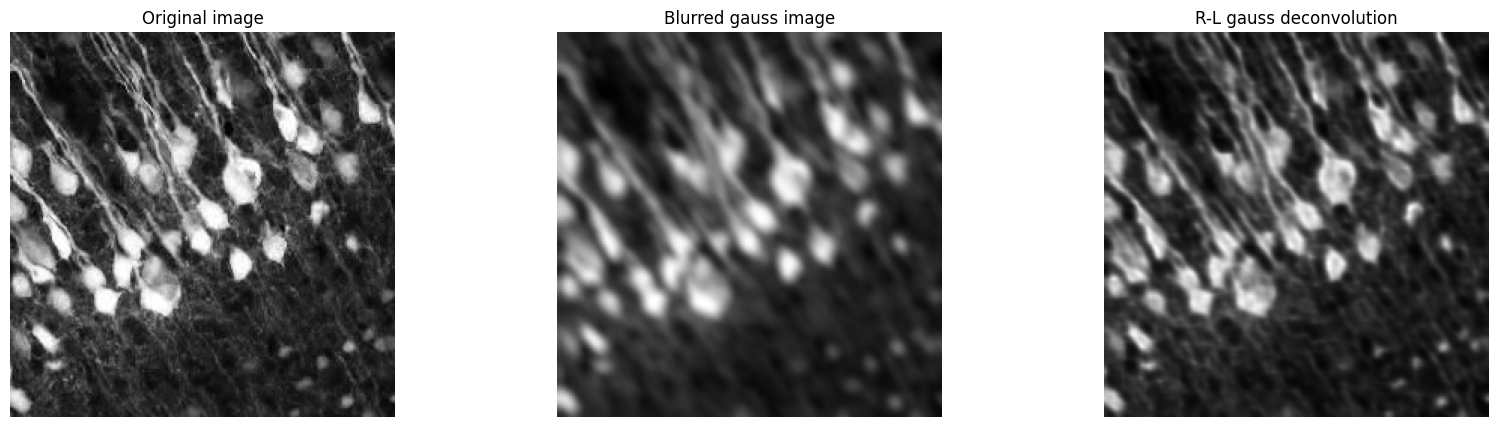

In [77]:
# für uniforme PSF

plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(img, 'gray')
plt.title('Original image')
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(blurred_uniform, 'gray')
plt.title('Blurred image')
plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(deconv_uniform, 'gray')
plt.title('R-L deconvolution')
plt.show()

# für Gauß PSF

plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(img, 'gray')
plt.title('Original image')
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(blurred_gauss, 'gray')
plt.title('Blurred gauss image')
plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(deconv_gauss, 'gray')
plt.title('R-L gauss deconvolution')
plt.show()


**[Task 5.]()** Add noise to the image, use the R-L deconvolution again.

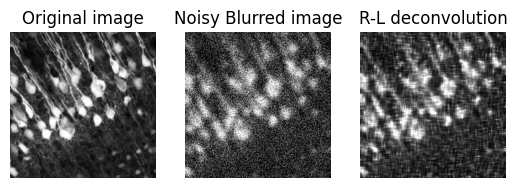

In [78]:
noise = (np.random.normal(loc=0,size=img.shape))
reduce_factor = 5
noise = noise / reduce_factor

noisy_blurred_uniform = blurred_uniform + noise
noisy_blurred_uniform = np.clip(noisy_blurred_uniform, 0, 1)

deconv_noisy_uniform = richardson_lucy_deconvolution(noisy_blurred_uniform, psf_uniform, 10)

plt.figure()
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(img, 'gray')
plt.title('Original image')
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(noisy_blurred_uniform, 'gray')
plt.title('Noisy Blurred image')
plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(deconv_noisy_uniform, 'gray')
plt.title('R-L deconvolution')
plt.show()  

**[Task 6.]()** Compare your R-L implementation to a wiener deconvolution.

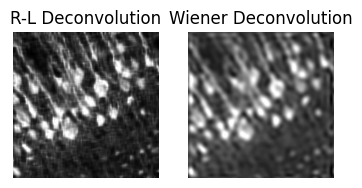

In [79]:
deconv_uniform = richardson_lucy_deconvolution(blurred_uniform, psf_uniform, 100)
deconv_wiener = wiener(blurred_uniform, psf_uniform, balance = 1, clip = True)

plt.figure()
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(deconv_uniform, "gray")
plt.title( "R-L Deconvolution")
plt.subplot(1, 3, 2)
plt.axis("off")
plt.imshow(deconv_wiener, "gray")
plt.title("Wiener Deconvolution")
plt.show()

**[Task 7.]()** Repeat Tasks 4–6 using a smaller value for the size of the PSF.

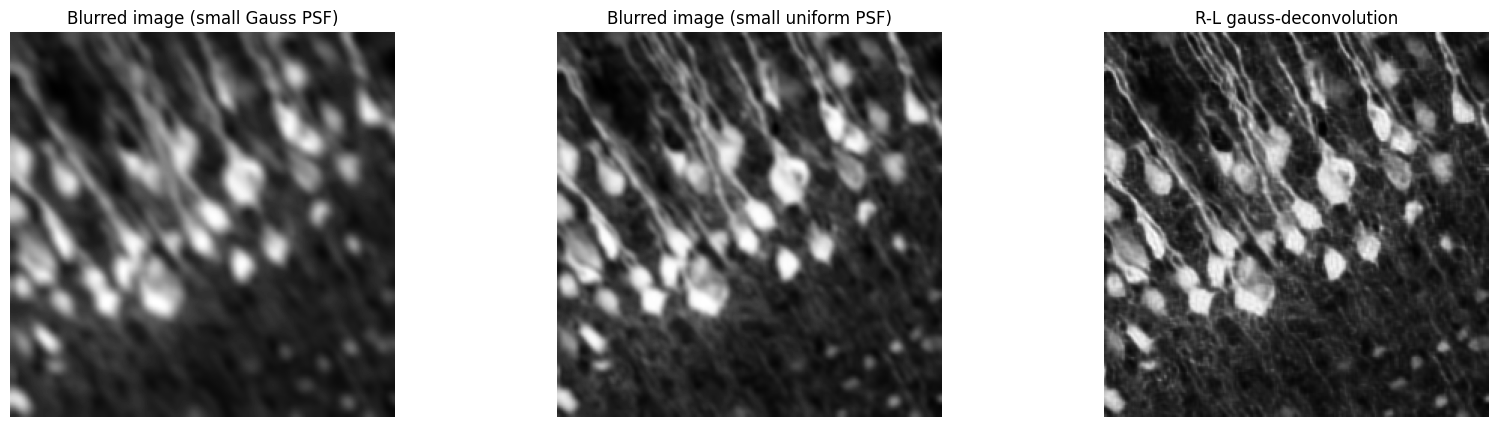

In [80]:
smaller_psf_size = 5

small_psf_uniform = create_psf(smaller_psf_size)
small_psf_gauss = create_psf(smaller_psf_size)

blurred_small_uniform = conv(img, small_psf_uniform, mode="same", boundary="symm")
blurred_small_gauss = conv(img, small_psf_gauss, mode="same", boundary="symm")

deconv_small_uniform = richardson_lucy_deconvolution(blurred_small_uniform, small_psf_uniform, 100)
deconv_small_gauss = richardson_lucy_deconvolution(blurred_small_gauss, small_psf_gauss, 100)

plt.figure(figsize=(20,5))  
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(img, 'gray')
plt.title('Original image')
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(blurred_small_uniform, 'gray')
plt.title('Blurred image (small uniform PSF)')
plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(deconv_small_uniform, 'gray')
plt.title('R-L deconvolution')
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(blurred_gauss, 'gray')
plt.title('Blurred image (small Gauss PSF)')
plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(deconv_small_gauss, 'gray')
plt.title('R-L gauss-deconvolution')
plt.show() 


**[Task 8.]()** Use a wrong PSF to restore the image

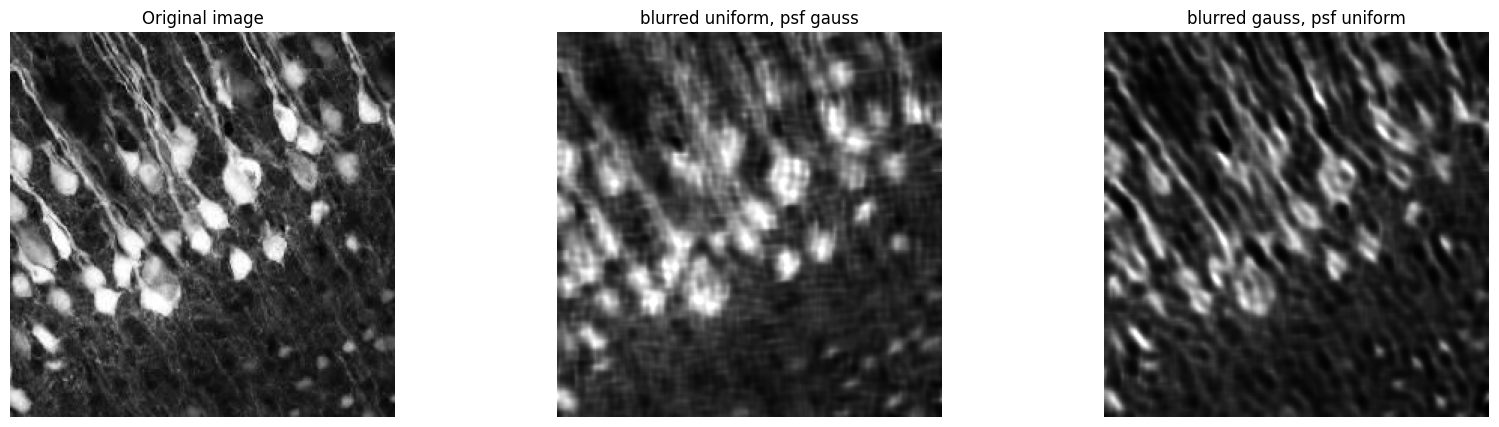

In [81]:
deconv_uniform_wrong = richardson_lucy_deconvolution(blurred_gauss, psf_uniform, 100)
deconv_gauss_wrong = richardson_lucy_deconvolution(blurred_uniform, psf_gauss, 100)

plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(img, 'gray')
plt.title('Original image')

plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(deconv_gauss_wrong, 'gray')
plt.title('blurred uniform, psf gauss')

plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(deconv_uniform_wrong, 'gray')
plt.title('blurred gauss, psf uniform')
plt.show()

Folge: kanten strukturen etc. wirken verschwommen, wurde falsch rekonstruiert.

        effekte die auf original bild nicht sind erscheinen.

        Strukturen sind kleiner bzw anders als auf originalem bild 

        rekonstruiertes bild entspricht nur in sehr grober entfernter weise dem originalen bild 